In [14]:
# INSTRUCCIÓN: Ejecutar esta celda primero para cargar todas las librerías necesarias

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import random
from itertools import product
import warnings
warnings.filterwarnings('ignore')

# Fijar semillas para reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("✓ Librerías importadas correctamente")
print(f"TensorFlow version: {tf.__version__}")

✓ Librerías importadas correctamente
TensorFlow version: 2.20.0


In [15]:
#INSTRUCCIÓN: Ejecutar para cargar el CSV y hacer preprocesamiento básico

df = pd.read_csv("registros_rio_6746.csv")

# Modificar columnas del df
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(by="date")
df = df.drop(columns=['es_null', 'year'])

# Agregar columnas futuras (las vamos a eliminar después)
df['altura_7_dias'] = df['altura_value'].shift(periods=-7)
df['precipitaciones_7_dias'] = df['precipitaciones_value'].shift(periods=-7)
df = df.iloc[:1001].copy()  # elimino las ultimas 7 ya que tienen datos del futuro

print(f"✓ Datos cargados: {len(df)} registros")
print(f"  Rango de fechas: {df['date'].min()} a {df['date'].max()}")

✓ Datos cargados: 1001 registros
  Rango de fechas: 2023-01-02 00:00:00 a 2025-09-28 00:00:00


In [16]:
# INSTRUCCIÓN: Ejecutar para agregar la columna de estación del año con One-Hot Encoding

import pandas as pd

def obtener_estacion(fecha):
    mes = fecha.month
    dia = fecha.day
    
    if (mes == 12 and dia >= 21) or (mes <= 3 and (mes < 3 or dia <= 20)):
        return "verano"
    elif (mes == 3 and dia >= 21) or (mes <= 6 and (mes < 6 or dia <= 20)):
        return "otoño"
    elif (mes == 6 and dia >= 21) or (mes <= 9 and (mes < 9 or dia <= 20)):
        return "invierno"
    else:
        return "primavera"

# Crear la columna base
df['estacion'] = df['date'].apply(obtener_estacion)

# Aplicar One-Hot Encoding
df = pd.get_dummies(df, columns=['estacion'], prefix='est')

print("✓ Columnas de estación creadas con One-Hot Encoding\n")
print("Nuevas columnas:")
print([col for col in df.columns if col.startswith("est_")])



✓ Columnas de estación creadas con One-Hot Encoding

Nuevas columnas:
['est_invierno', 'est_otoño', 'est_primavera', 'est_verano']


In [17]:
# INSTRUCCIÓN: Ejecutar para eliminar columnas que no usaremos

columnas_a_eliminar = ['rio_id', 'lat', 'lon', 'altura_7_dias', 'precipitaciones_7_dias']
df = df.drop(columns=columnas_a_eliminar, errors='ignore')

print(f"✓ Columnas limpiadas")
print(f"  Columnas finales: {list(df.columns)}") 
''' 
TENGO QUE SEGUIR DESDE ABAJO DE ESTA CELDA MODIFICANDO PARA QUE ME TOME LAS COLUMNAS DEL ONE HOT
Y NO SE ROMPA TODO. Tambien para agregar la fila que me dijo chat despues de entrenar.
'''

✓ Columnas limpiadas
  Columnas finales: ['date', 'altura_value', 'precipitaciones_value', 'est_invierno', 'est_otoño', 'est_primavera', 'est_verano']


' \nTENGO QUE SEGUIR DESDE ABAJO DE ESTA CELDA MODIFICANDO PARA QUE ME TOME LAS COLUMNAS DEL ONE HOT\nY NO SE ROMPA TODO. Tambien para agregar la fila que me dijo chat despues de entrenar.\n'

In [18]:
# INSTRUCCIÓN: CRÍTICO - Esta celda separa los datos ANTES de hacer K-Fold
# El test set NO se tocará hasta el final

# Primero separamos el TEST SET (20% final del dataset)
# Este conjunto NO se usará para nada hasta la evaluación final
test_size = 0.20
split_point = int(len(df) * (1 - test_size))

df_train_val = df.iloc[:split_point].copy()  # 80% para train+validation
df_test = df.iloc[split_point:].copy()       # 20% para test final

print("=" * 80)
print("SEPARACIÓN DE DATOS")
print("=" * 80)
print(f"Dataset completo: {len(df)} registros")
print(f"Train+Validation: {len(df_train_val)} registros (80%)")
print(f"Test (guardado para el final): {len(df_test)} registros (20%)")
print("\n⚠️ IMPORTANTE: El test set NO se usará hasta la evaluación final")
print("=" * 80)


SEPARACIÓN DE DATOS
Dataset completo: 1001 registros
Train+Validation: 800 registros (80%)
Test (guardado para el final): 201 registros (20%)

⚠️ IMPORTANTE: El test set NO se usará hasta la evaluación final


In [19]:
# INSTRUCCIÓN: Ejecutar para definir la función de ventanas deslizantes (versión actualizada con One-Hot Encoding)

import numpy as np

# Actualizamos las features incluyendo las columnas de estación
features = ['altura_value', 'precipitaciones_value',
            'est_verano', 'est_otoño', 'est_invierno', 'est_primavera']


def crear_ventanas(df, window_size=3):
    """
    Crea ventanas deslizantes que usan los últimos 'window_size' días de historia
    más la precipitación y estación del día siguiente para predecir la altura del día siguiente.
    """
    X = []
    y = []

    for i in range(window_size, len(df) - 1):  # hasta len(df)-1 porque miramos el día siguiente
        # Días pasados (historia)
        ventana = df[[
            'altura_value', 'precipitaciones_value',
            'est_verano', 'est_otoño', 'est_invierno', 'est_primavera'
        ]].iloc[i-window_size:i].values.flatten()
        
        # Datos del día futuro (precipitaciones y estación de mañana)
        futuro = df[[
            'precipitaciones_value',
            'est_verano', 'est_otoño', 'est_invierno', 'est_primavera'
        ]].iloc[i].values.flatten()

        # Concatenamos historia + futuro
        features = np.concatenate([ventana, futuro])
        X.append(features)

        # Target: altura de mañana
        y.append(df['altura_value'].iloc[i])

    return np.array(X), np.array(y)

print("✓ Función crear_ventanas() actualizada con One-Hot Encoding")


✓ Función crear_ventanas() actualizada con One-Hot Encoding


In [24]:
# INSTRUCCIÓN: Ejecutar para definir el K-Fold temporal (respeta el orden cronológico)

class TimeSeriesKFold:
    """
    K-Fold Cross-Validation para series temporales.
    Respeta el orden temporal: cada fold usa datos pasados para entrenar
    y datos futuros para validar.
    """
    def __init__(self, n_splits=5):
        self.n_splits = n_splits
    
    def split(self, X):
        n_samples = len(X)
        fold_size = n_samples // (self.n_splits + 1)
        
        for i in range(self.n_splits):
            # Train: desde el inicio hasta el punto de corte
            train_end = fold_size * (i + 2)
            train_indices = np.arange(0, train_end - fold_size)
            
            # Validation: el fold siguiente
            val_start = train_end - fold_size
            val_end = train_end
            val_indices = np.arange(val_start, val_end)
            
            yield train_indices, val_indices

print("✓ TimeSeriesKFold definido")


✓ TimeSeriesKFold definido


In [20]:
# INSTRUCCIÓN: Ejecutar para definir la función que crea modelos

def crear_modelo(input_shape, arquitectura, learning_rate=0.001):
    """
    Crea un modelo de red neuronal con la arquitectura especificada.
    
    Args:
        input_shape: Número de features de entrada
        arquitectura: Lista con número de neuronas por capa, ej: [64, 32, 16]
        learning_rate: Tasa de aprendizaje del optimizador
        
    Returns:
        Modelo compilado
    """
    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    # Agregar capas ocultas
    for neurons in arquitectura:
        model.add(layers.Dense(neurons, activation='relu'))
    
    # Capa de salida
    model.add(layers.Dense(1))
    
    # Compilar
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

print("✓ Función crear_modelo() definida")


✓ Función crear_modelo() definida


In [14]:
# INSTRUCCIÓN: Ejecutar para definir qué hiperparámetros probar
# PUEDES MODIFICAR ESTOS VALORES según lo que quieras probar

# Hiperparámetros a probar
HYPERPARAMETERS = {
    'window_size': [3, 5, 7],  # Tamaños de ventana
    'arquitectura': [
        [64, 32, 16],      # Red profunda
        [128, 64],         # Red ancha
        [32, 32, 32],      # Red uniforme
        [64, 32],          # Red simple
    ],
    'learning_rate': [0.001, 0.0001],  # Tasas de aprendizaje
}

# Configuración del experimento
N_SPLITS = 5           # Número de folds para K-Fold
EPOCHS = 100           # Épocas de entrenamiento
BATCH_SIZE = 32        # Tamaño del batch
VERBOSE = 0            # 0=silencioso, 1=verbose

print("=" * 80)
print("CONFIGURACIÓN DEL EXPERIMENTO")
print("=" * 80)
print(f"K-Fold splits: {N_SPLITS}")
print(f"Épocas por modelo: {EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print("\nHiperparámetros a validar:")
print(f"  - Window sizes: {HYPERPARAMETERS['window_size']}")
print(f"  - Arquitecturas: {len(HYPERPARAMETERS['arquitectura'])} variantes")
print(f"  - Learning rates: {HYPERPARAMETERS['learning_rate']}")

# Calcular total de configuraciones
total_configs = (len(HYPERPARAMETERS['window_size']) * 
                 len(HYPERPARAMETERS['arquitectura']) * 
                 len(HYPERPARAMETERS['learning_rate']))
total_entrenamientos = total_configs * N_SPLITS

print(f"\nTotal de configuraciones: {total_configs}")
print(f"Total de entrenamientos: {total_entrenamientos}")
print(f"⏱️ Tiempo estimado: ~{total_entrenamientos * 2 // 60} minutos")
print("=" * 80)

CONFIGURACIÓN DEL EXPERIMENTO
K-Fold splits: 5
Épocas por modelo: 100
Batch size: 32

Hiperparámetros a validar:
  - Window sizes: [3, 5, 7]
  - Arquitecturas: 4 variantes
  - Learning rates: [0.001, 0.0001]

Total de configuraciones: 24
Total de entrenamientos: 120
⏱️ Tiempo estimado: ~4 minutos


In [11]:
# INSTRUCCIÓN: ⚠️ ESTA ES LA CELDA PRINCIPAL - Puede tardar varios minutos
# Esta celda ejecuta todo el proceso de validación cruzada

print("\n" + "=" * 80)
print("INICIANDO K-FOLD CROSS-VALIDATION")
print("=" * 80)

resultados = []
config_num = 0

# Iterar sobre todas las combinaciones de hiperparámetros
for window_size, arquitectura, lr in product(
    HYPERPARAMETERS['window_size'],
    HYPERPARAMETERS['arquitectura'],
    HYPERPARAMETERS['learning_rate']
):
    config_num += 1
    
    print(f"\n{'=' * 80}")
    print(f"CONFIGURACIÓN {config_num}/{total_configs}")
    print(f"{'=' * 80}")
    print(f"  Window size: {window_size}")
    print(f"  Arquitectura: {arquitectura}")
    print(f"  Learning rate: {lr}")
    
    # Crear ventanas con este window_size usando SOLO train+val data
    X, y = crear_ventanas(df_train_val, features, window_size=window_size)
    
    # Inicializar K-Fold
    kfold = TimeSeriesKFold(n_splits=N_SPLITS)
    
    # Almacenar scores de cada fold
    fold_scores = []
    
    # Iterar sobre cada fold
    for fold_num, (train_idx, val_idx) in enumerate(kfold.split(X), 1):
        print(f"  → Fold {fold_num}/{N_SPLITS}... ", end='')
        
        # Separar train y validation para este fold
        X_train_fold = X[train_idx]
        y_train_fold = y[train_idx]
        X_val_fold = X[val_idx]
        y_val_fold = y[val_idx]
        
        # Escalar datos (IMPORTANTE: fit solo en train)
        scaler_X_fold = MinMaxScaler()
        scaler_y_fold = MinMaxScaler()
        
        X_train_scaled = scaler_X_fold.fit_transform(X_train_fold)
        X_val_scaled = scaler_X_fold.transform(X_val_fold)
        
        y_train_scaled = scaler_y_fold.fit_transform(y_train_fold.reshape(-1, 1)).flatten()
        y_val_scaled = scaler_y_fold.transform(y_val_fold.reshape(-1, 1)).flatten()
        
        # Crear modelo
        tf.random.set_seed(SEED + fold_num)
        model = crear_modelo(X_train_scaled.shape[1], arquitectura, lr)
        
        # Entrenar
        history = model.fit(
            X_train_scaled, y_train_scaled,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            validation_data=(X_val_scaled, y_val_scaled),
            verbose=VERBOSE
        )
        
        # Evaluar en validation
        y_pred_scaled = model.predict(X_val_scaled, verbose=0)
        y_pred = scaler_y_fold.inverse_transform(y_pred_scaled)
        y_val_real = scaler_y_fold.inverse_transform(y_val_fold.reshape(-1, 1))
        
        # Calcular métricas
        mae = mean_absolute_error(y_val_real, y_pred)
        rmse = np.sqrt(mean_squared_error(y_val_real, y_pred))
        
        fold_scores.append({
            'mae': mae,
            'rmse': rmse
        })
        
        print(f"MAE: {mae:.4f}m")
    
    # Calcular promedios de los folds
    mae_mean = np.mean([s['mae'] for s in fold_scores])
    mae_std = np.std([s['mae'] for s in fold_scores])
    rmse_mean = np.mean([s['rmse'] for s in fold_scores])
    rmse_std = np.std([s['rmse'] for s in fold_scores])
    
    # Guardar resultados de esta configuración
    resultados.append({
        'window_size': window_size,
        'arquitectura': str(arquitectura),
        'learning_rate': lr,
        'mae_mean': mae_mean,
        'mae_std': mae_std,
        'rmse_mean': rmse_mean,
        'rmse_std': rmse_std,
        'mae_folds': [s['mae'] for s in fold_scores],
        'rmse_folds': [s['rmse'] for s in fold_scores]
    })
    
    print(f"\n  📊 Resultado promedio ({N_SPLITS} folds):")
    print(f"     MAE: {mae_mean:.4f} ± {mae_std:.4f} m")
    print(f"     RMSE: {rmse_mean:.4f} ± {rmse_std:.4f} m")

print("\n" + "=" * 80)
print("✓ VALIDACIÓN CRUZADA COMPLETADA")
print("=" * 80)



INICIANDO K-FOLD CROSS-VALIDATION

CONFIGURACIÓN 1/24
  Window size: 3
  Arquitectura: [64, 32, 16]
  Learning rate: 0.001
  → Fold 1/5... MAE: 0.0022m
  → Fold 2/5... MAE: 0.0230m
  → Fold 3/5... WARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001ACDFCFA160> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
MAE: 0.2251m
  → Fold 4/5... MAE: 0.2591m
  → Fold 5/5... MAE: 0.0879m

  📊

In [12]:
df_resultados = pd.DataFrame(resultados)

# Ordenar por MAE (menor es mejor)
df_resultados_sorted = df_resultados.sort_values('mae_mean')

print("\n" + "=" * 80)
print("TOP 5 MEJORES CONFIGURACIONES (según MAE)")
print("=" * 80)
print("\nWindow | Arquitectura    | LR     | MAE (m)         | RMSE (m)")
print("-" * 80)

for idx, row in df_resultados_sorted.head(5).iterrows():
    print(f"{row['window_size']:^6} | {row['arquitectura']:^15} | {row['learning_rate']:.4f} | "
          f"{row['mae_mean']:.4f}±{row['mae_std']:.4f} | "
          f"{row['rmse_mean']:.4f}±{row['rmse_std']:.4f}")

# Mejor configuración
mejor_config = df_resultados_sorted.iloc[0]

print("\n" + "=" * 80)
print("🏆 MEJOR CONFIGURACIÓN ENCONTRADA")
print("=" * 80)
print(f"  Window size: {mejor_config['window_size']}")
print(f"  Arquitectura: {mejor_config['arquitectura']}")
print(f"  Learning rate: {mejor_config['learning_rate']}")
print(f"  MAE: {mejor_config['mae_mean']:.4f} ± {mejor_config['mae_std']:.4f} m")
print(f"  RMSE: {mejor_config['rmse_mean']:.4f} ± {mejor_config['rmse_std']:.4f} m")
print("=" * 80)

# Guardar resultados completos
df_resultados_sorted.to_csv('resultados_kfold_validation.csv', index=False)
# print("\n✓ Resultados guardados en 'resultados_kfold_validation.csv'")


TOP 5 MEJORES CONFIGURACIONES (según MAE)

Window | Arquitectura    | LR     | MAE (m)         | RMSE (m)
--------------------------------------------------------------------------------
  3    |    [64, 32]     | 0.0001 | 0.1167±0.0930 | 0.1450±0.1309
  3    |  [32, 32, 32]   | 0.0001 | 0.1172±0.0940 | 0.1420±0.1216
  3    |  [64, 32, 16]   | 0.0010 | 0.1195±0.1046 | 0.1438±0.1315
  5    |  [32, 32, 32]   | 0.0001 | 0.1235±0.1010 | 0.1507±0.1317
  3    |    [64, 32]     | 0.0010 | 0.1243±0.1053 | 0.1489±0.1335

🏆 MEJOR CONFIGURACIÓN ENCONTRADA
  Window size: 3
  Arquitectura: [64, 32]
  Learning rate: 0.0001
  MAE: 0.1167 ± 0.0930 m
  RMSE: 0.1450 ± 0.1309 m


In [23]:
# Parámetros de entrenamiento
EPOCHS = 100        # número de veces que recorre todo el dataset (ajustá según rendimiento)
BATCH_SIZE = 32     # tamaño de los lotes de entrenamiento

print(f"Configuración de entrenamiento -> EPOCHS: {EPOCHS}, BATCH_SIZE: {BATCH_SIZE}")


Configuración de entrenamiento -> EPOCHS: 100, BATCH_SIZE: 32


In [24]:
print("\n" + "=" * 80)
print("ENTRENANDO MODELO FINAL CON MEJORES HIPERPARÁMETROS")
print("=" * 80)

# Extraer mejores hiperparámetros
best_window = 3 #int(mejor_config['window_size'])
best_arquitectura = [64, 32] #eval(mejor_config['arquitectura'])
best_lr = 0.0001 #(mejor_config['learning_rate'])

print(f"\nUsando configuración óptima:")
print(f"  Window size: {best_window}")
print(f"  Arquitectura: {best_arquitectura}")
print(f"  Learning rate: {best_lr}")

# Crear ventanas con TODO el train+val set
X_train_final, y_train_final = crear_ventanas(df_train_val, window_size=best_window)

# Escalar datos
scaler_X_final = MinMaxScaler()
scaler_y_final = MinMaxScaler()

X_train_final_scaled = scaler_X_final.fit_transform(X_train_final)
y_train_final_scaled = scaler_y_final.fit_transform(y_train_final.reshape(-1, 1)).flatten()

# ✅ Guardar los scalers para usar luego en predicción
import joblib
joblib.dump(scaler_X_final, "scaler_X_final.pkl")
joblib.dump(scaler_y_final, "scaler_y_final.pkl")

print("✓ Scalers guardados: 'scaler_X_final.pkl' y 'scaler_y_final.pkl'")

# Crear y entrenar modelo final
print("\n🔄 Entrenando modelo final...")
tf.random.set_seed(SEED)
modelo_final = crear_modelo(X_train_final_scaled.shape[1], best_arquitectura, best_lr)

history_final = modelo_final.fit(
    X_train_final_scaled, y_train_final_scaled,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,  # Solo para monitorear, no para seleccionar hiperparámetros
    verbose=1
)

print("\n✓ Modelo final entrenado exitosamente")

# Guardar modelo
modelo_final.save('modelo_final_optimizado.h5')
print("✓ Modelo guardado en 'modelo_final_optimizado.h5'")


ENTRENANDO MODELO FINAL CON MEJORES HIPERPARÁMETROS

Usando configuración óptima:
  Window size: 3
  Arquitectura: [64, 32]
  Learning rate: 0.0001
✓ Scalers guardados: 'scaler_X_final.pkl' y 'scaler_y_final.pkl'

🔄 Entrenando modelo final...
Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - loss: 0.1557 - mae: 0.3408 - val_loss: 0.0545 - val_mae: 0.2000
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.1113 - mae: 0.2850 - val_loss: 0.0375 - val_mae: 0.1652
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0783 - mae: 0.2337 - val_loss: 0.0277 - val_mae: 0.1409
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0545 - mae: 0.1933 - val_loss: 0.0226 - val_mae: 0.1251
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0386 - mae: 0.1663 - val_loss: 0.0201 - val_mae: 0.1179
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0277 - mae: 0.1438 - val_loss: 0.0184 - val_mae: 0.1138
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/s


✓ Modelo final entrenado exitosamente
✓ Modelo guardado en 'modelo_final_optimizado.h5'


In [17]:
# INSTRUCCIÓN: Ejecutar para evaluar el modelo final en el test set guardado

print("\n" + "=" * 80)
print("EVALUACIÓN FINAL EN TEST SET")
print("=" * 80)
print("⚠️ Esta es la PRIMERA vez que usamos el test set")

# Crear ventanas para el test set
X_test_final, y_test_final = crear_ventanas(df_test, features, window_size=best_window)

# Escalar test set (usando scalers entrenados en train+val)
X_test_final_scaled = scaler_X_final.transform(X_test_final)

# Hacer predicciones
y_pred_test_scaled = modelo_final.predict(X_test_final_scaled, verbose=0)
y_pred_test = scaler_y_final.inverse_transform(y_pred_test_scaled)
y_test_real = y_test_final.reshape(-1, 1)

# Calcular métricas finales
mae_test = mean_absolute_error(y_test_real, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test_real, y_pred_test))
rango_total = df["altura_value"].max() - df["altura_value"].min()
error_pct = (mae_test / rango_total) * 100

print(f"\n📊 RESULTADOS FINALES EN TEST SET:")
print(f"  MAE: {mae_test:.4f} m")
print(f"  RMSE: {rmse_test:.4f} m")
print(f"  Error porcentual: {error_pct:.2f}%")

print(f"\n📈 Comparación con validación cruzada:")
print(f"  MAE en K-Fold: {mejor_config['mae_mean']:.4f} ± {mejor_config['mae_std']:.4f} m")
print(f"  MAE en Test: {mae_test:.4f} m")
diferencia = abs(mae_test - mejor_config['mae_mean'])
print(f"  Diferencia: {diferencia:.4f} m")

if diferencia < mejor_config['mae_std']:
    print("  ✓ El test set confirma los resultados de K-Fold")
else:
    print("  ⚠️ Hay una diferencia notable - posible overfitting en la validación")

print("=" * 80)

# Visualizar predicciones vs reales en test
plt.figure(figsize=(15, 5))
plt.plot(y_test_real[:100], label='Real', marker='o', alpha=0.7)
plt.plot(y_pred_test[:100], label='Predicción', marker='x', alpha=0.7)
plt.xlabel('Muestra', fontsize=12)
plt.ylabel('Altura (metros)', fontsize=12)
plt.title('Predicciones vs Valores Reales en Test Set (primeras 100 muestras)', 
          fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('predicciones_test_final.png', dpi=300, bbox_inches='tight')
plt.show()

# print("\n✓ Gráfico guardado en 'predicciones_test_final.png'")


EVALUACIÓN FINAL EN TEST SET
⚠️ Esta es la PRIMERA vez que usamos el test set

📊 RESULTADOS FINALES EN TEST SET:
  MAE: 0.0471 m
  RMSE: 0.0711 m
  Error porcentual: 3.71%

📈 Comparación con validación cruzada:


NameError: name 'mejor_config' is not defined


PREDICCIONES ITERATIVAS - HORIZONTE 7 DÍAS
(Usando modelo optimizado con K-Fold)

INFORMACIÓN DE ÍNDICES PARA TEST SET
Tamaño del dataframe original: 1001
Split point (inicio del test en df): 800
Tamaño de X_test_final: 198
Tamaño de y_test_final: 198
Window size usado: 3

Datos válidos para predicción iterativa: 191
(Descartamos últimos 7 porque no tienen precipitaciones futuras)

Índice máximo que necesitamos del df_test:
  best_window + (n_test_validos-1) + 7 = 200
  Tamaño del df_test: 201

✓ OK: Tenemos suficientes datos en df_test

🔄 Realizando predicciones iterativas...
  Procesando muestra 180/191...
✓ Predicciones iterativas completadas

MÉTRICAS POR HORIZONTE TEMPORAL

Horizonte       MAE (m)      RMSE (m)     Error %      Deterioro MAE  
--------------------------------------------------------------------------------
Día +1        0.0496      0.0779      3.90%      -
Día +2        0.0629      0.0912      4.96%      +26.9%
Día +3        0.0794      0.1051      6.25%      +60

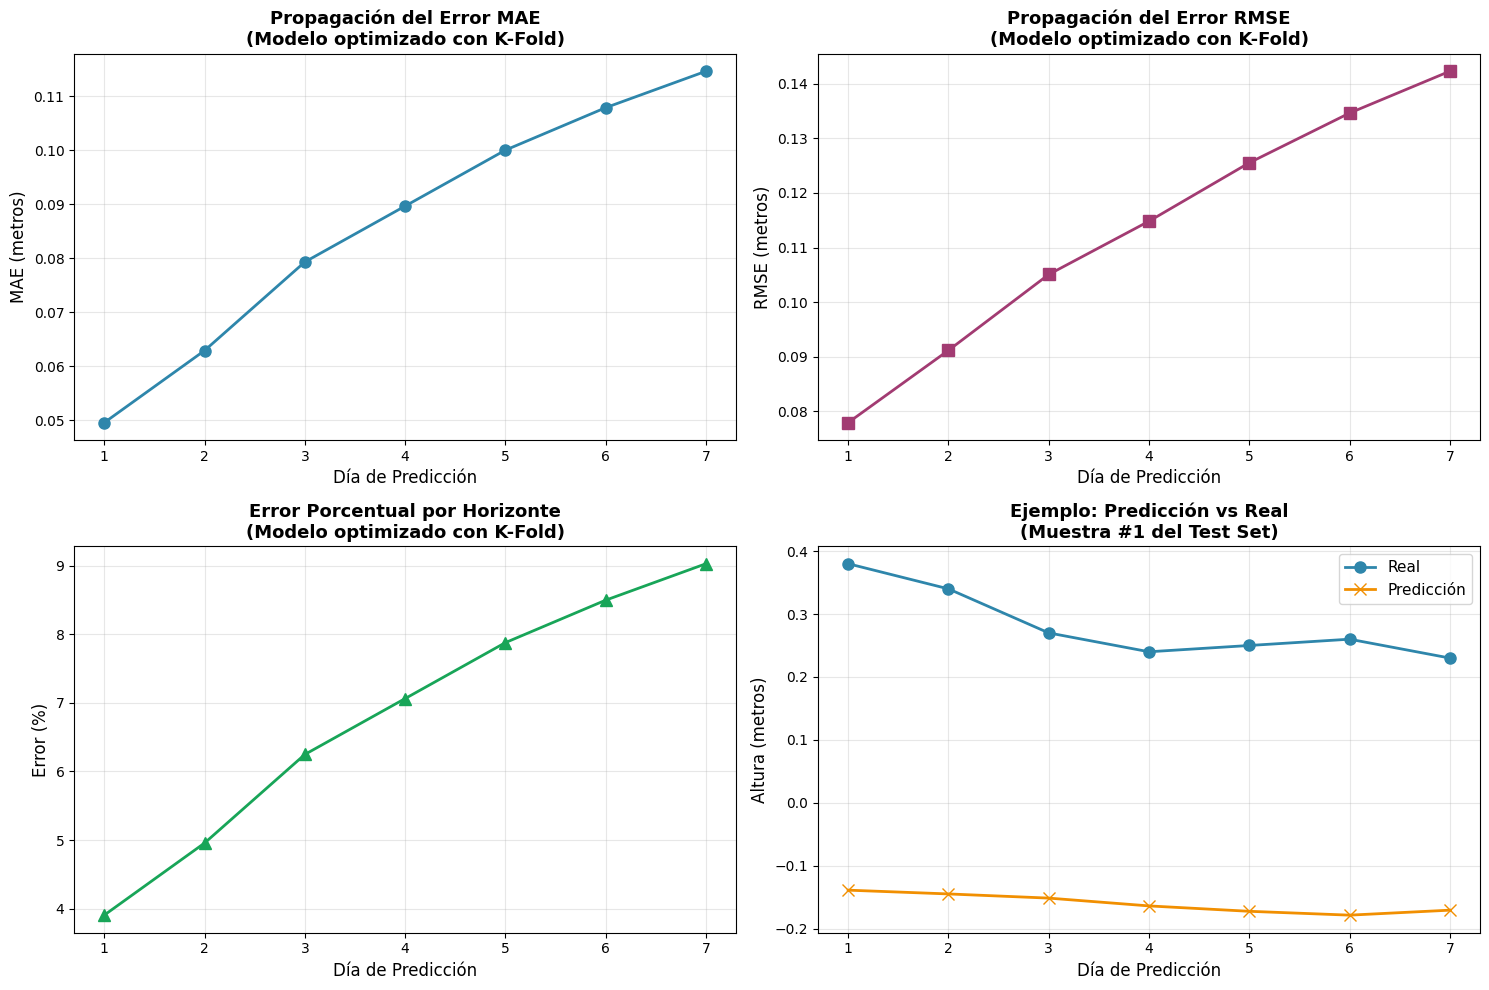


✓ Gráficos guardados en 'predicciones_iterativas_7dias_optimizado.png'
✓ Resultados guardados en 'resultados_prediccion_iterativa_optimizado.csv'

ANÁLISIS DE DISTRIBUCIÓN DE ERRORES


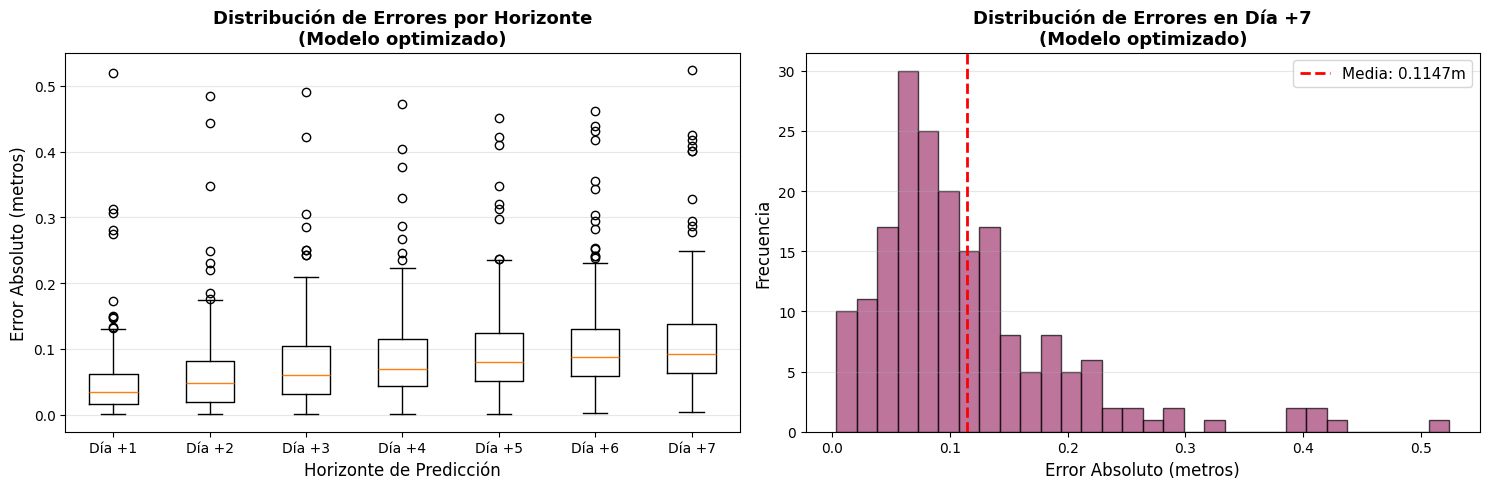


✓ Análisis guardado en 'analisis_errores_iterativos.png'

✅ PIPELINE COMPLETO EJECUTADO

📋 Lo que se hizo correctamente:
  1. ✓ Separamos test set (20%) al principio y NO lo tocamos
  2. ✓ Usamos K-Fold Cross-Validation en train+val (80%)
  3. ✓ Probamos múltiples hiperparámetros con validación cruzada
  4. ✓ Encontramos la mejor configuración sin 'espiar' el test
  5. ✓ Entrenamos modelo final con mejores hiperparámetros
  6. ✓ Evaluamos UNA SOLA VEZ en el test set

🎯 Ahora los resultados son confiables y generalizables


In [15]:
print("\n" + "=" * 80)
print("PREDICCIONES ITERATIVAS - HORIZONTE 7 DÍAS")
print("(Usando modelo optimizado con K-Fold)")
print("=" * 80)

# Función para obtener la estación según la fecha
def obtener_estacion_fecha(fecha):
    mes = fecha.month
    dia = fecha.day
    
    if (mes == 12 and dia >= 21) or (mes <= 3 and (mes < 3 or dia <= 20)):
        return 0  # Verano
    elif (mes == 3 and dia >= 21) or (mes <= 6 and (mes < 6 or dia <= 20)):
        return 1  # Otoño
    elif (mes == 6 and dia >= 21) or (mes <= 9 and (mes < 9 or dia <= 20)):
        return 2  # Invierno
    else:
        return 3  # Primavera

# Crear scalers individuales para cada feature usando el scaler_X_final
# El scaler tiene best_window * 3 features (ej: 3 días * 3 features = 9)
scaler_altura_min = scaler_X_final.data_min_[0]
scaler_altura_max = scaler_X_final.data_max_[0]
scaler_precip_min = scaler_X_final.data_min_[1]
scaler_precip_max = scaler_X_final.data_max_[1]
scaler_estacion_min = scaler_X_final.data_min_[2]
scaler_estacion_max = scaler_X_final.data_max_[2]

def escalar_valor(valor, min_val, max_val):
    """Escala un valor individual usando los límites del scaler"""
    if max_val - min_val == 0:
        return 0
    return (valor - min_val) / (max_val - min_val)

# ============================================================================
# ANÁLISIS DE ÍNDICES PARA TEST SET
# ============================================================================
print("\n" + "=" * 80)
print("INFORMACIÓN DE ÍNDICES PARA TEST SET")
print("=" * 80)

# Calcular el índice donde empieza el test en el dataframe original
# Como separamos df_test desde split_point, necesitamos saber dónde está
split_point_original = len(df_train_val)

print(f"Tamaño del dataframe original: {len(df)}")
print(f"Split point (inicio del test en df): {split_point_original}")
print(f"Tamaño de X_test_final: {len(X_test_final)}")
print(f"Tamaño de y_test_final: {len(y_test_final)}")
print(f"Window size usado: {best_window}")

# No podemos usar los últimos 7 registros como punto de partida
n_test_validos = len(X_test_final) - 7

print(f"\nDatos válidos para predicción iterativa: {n_test_validos}")
print(f"(Descartamos últimos 7 porque no tienen precipitaciones futuras)")

# Verificar límites en el dataframe test
# X_test_final[0] usa df_test[0:best_window] -> predice df_test[best_window]
idx_maximo_necesario_test = best_window + n_test_validos - 1 + 7
print(f"\nÍndice máximo que necesitamos del df_test:")
print(f"  best_window + (n_test_validos-1) + 7 = {idx_maximo_necesario_test}")
print(f"  Tamaño del df_test: {len(df_test)}")

if idx_maximo_necesario_test >= len(df_test):
    print(f"\n⚠️ PROBLEMA: Nos quedamos sin datos en df_test!")
    print(f"  Necesitamos hasta índice {idx_maximo_necesario_test}")
    print(f"  Pero df_test solo llega hasta {len(df_test)-1}")
    n_test_validos_ajustado = len(df_test) - (best_window + 7)
    print(f"\n  SOLUCIÓN: Ajustando n_test_validos a {n_test_validos_ajustado}")
    n_test_validos = n_test_validos_ajustado
else:
    print(f"\n✓ OK: Tenemos suficientes datos en df_test")

print("=" * 80 + "\n")

# ============================================================================
# PREDICCIONES ITERATIVAS
# ============================================================================
predicciones_todos_horizontes = []
reales_todos_horizontes = []

print("🔄 Realizando predicciones iterativas...")

for idx in range(n_test_validos):
    if (idx + 1) % 20 == 0 or idx == 0:
        print(f"  Procesando muestra {idx + 1}/{n_test_validos}...", end='\r')
    
    predicciones_muestra = []
    reales_muestra = []
    
    # Ventana inicial (últimos best_window días reales, escalados)
    ventana_actual = X_test_final_scaled[idx].copy()
    
    # Predecir los próximos 7 días
    for dia_futuro in range(1, 8):
        # Hacer predicción con el modelo final optimizado
        pred_scaled = modelo_final.predict(ventana_actual.reshape(1, -1), verbose=0)[0][0]
        pred_real = scaler_y_final.inverse_transform([[pred_scaled]])[0][0]
        
        # Guardar predicción
        predicciones_muestra.append(pred_real)
        
        # Obtener el valor real de este día futuro desde y_test_final
        idx_futuro = idx + dia_futuro
        valor_real = y_test_final[idx_futuro]
        reales_muestra.append(valor_real)
        
        # Preparar ventana para siguiente predicción
        if dia_futuro < 7:
            # Calcular índice en df_test
            # X_test_final[idx] predice el día best_window+idx de df_test
            # Queremos el día dia_futuro días después de eso
            idx_df_test_futuro = best_window + idx + dia_futuro
            
            # Verificación de seguridad
            if idx_df_test_futuro >= len(df_test):
                print(f"\n⚠️ ERROR: idx_df_test_futuro={idx_df_test_futuro} >= len(df_test)={len(df_test)}")
                print(f"   idx={idx}, dia_futuro={dia_futuro}")
                break
            
            # Obtener precipitaciones reales del día futuro desde df_test
            precip_futuro = df_test['precipitaciones_value'].iloc[idx_df_test_futuro]
            
            # Obtener fecha del día futuro para calcular estación
            fecha_futuro = df_test['date'].iloc[idx_df_test_futuro]
            estacion_futuro = obtener_estacion_fecha(fecha_futuro)
            
            # Escalar cada valor individualmente
            altura_escalada = escalar_valor(pred_real, scaler_altura_min, scaler_altura_max)
            precip_escalada = escalar_valor(precip_futuro, scaler_precip_min, scaler_precip_max)
            estacion_escalada = escalar_valor(estacion_futuro, scaler_estacion_min, scaler_estacion_max)
            
            nuevo_punto_escalado = np.array([altura_escalada, precip_escalada, estacion_escalada])
            
            # Desplazar ventana: quitar primeros 3 valores (un día) y agregar nuevos 3
            ventana_actual = np.concatenate([ventana_actual[3:], nuevo_punto_escalado])
    
    predicciones_todos_horizontes.append(predicciones_muestra)
    reales_todos_horizontes.append(reales_muestra)

print("\n✓ Predicciones iterativas completadas")

# Convertir a arrays numpy
predicciones_todos_horizontes = np.array(predicciones_todos_horizontes)
reales_todos_horizontes = np.array(reales_todos_horizontes)

print("\n" + "=" * 80)
print("MÉTRICAS POR HORIZONTE TEMPORAL")
print("=" * 80)

# Calcular métricas para cada día
rango_total = df["altura_value"].max() - df["altura_value"].min()

print("\n{:<15} {:<12} {:<12} {:<12} {:<15}".format(
    "Horizonte", "MAE (m)", "RMSE (m)", "Error %", "Deterioro MAE"
))
print("-" * 80)

mae_dia_1 = None
for dia in range(7):
    preds_dia = predicciones_todos_horizontes[:, dia]
    reales_dia = reales_todos_horizontes[:, dia]
    
    mae = mean_absolute_error(reales_dia, preds_dia)
    rmse = np.sqrt(mean_squared_error(reales_dia, preds_dia))
    error_pct = (mae / rango_total) * 100
    
    if dia == 0:
        mae_dia_1 = mae
        deterioro = "-"
    else:
        deterioro = f"+{((mae / mae_dia_1 - 1) * 100):.1f}%"
    
    print(f"Día +{dia + 1:<8} {mae:.4f}      {rmse:.4f}      {error_pct:.2f}%      {deterioro}")

# Calcular promedio
print("\n" + "-" * 80)
mae_promedio = mean_absolute_error(reales_todos_horizontes.flatten(), 
                                    predicciones_todos_horizontes.flatten())
rmse_promedio = np.sqrt(mean_squared_error(reales_todos_horizontes.flatten(), 
                                             predicciones_todos_horizontes.flatten()))
error_pct_promedio = (mae_promedio / rango_total) * 100

print(f"{'PROMEDIO':<15} {mae_promedio:.4f}      {rmse_promedio:.4f}      {error_pct_promedio:.2f}%")

# Comparar con predicción simple (día +1)
print("\n" + "=" * 80)
print("COMPARACIÓN: Día +1 vs Promedio 7 días")
print("=" * 80)
print(f"MAE Día +1: {mae_dia_1:.4f} m")
print(f"MAE Promedio (7 días): {mae_promedio:.4f} m")
print(f"Deterioro total: +{((mae_promedio / mae_dia_1 - 1) * 100):.1f}%")
print("=" * 80)

# Visualización
print("\n" + "=" * 80)
print("VISUALIZACIÓN DE PROPAGACIÓN DEL ERROR")
print("=" * 80)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. MAE por día
ax1 = axes[0, 0]
dias = range(1, 8)
maes = [mean_absolute_error(reales_todos_horizontes[:, i], 
                             predicciones_todos_horizontes[:, i]) 
        for i in range(7)]
ax1.plot(dias, maes, marker='o', linewidth=2, markersize=8, color='#2E86AB')
ax1.set_xlabel('Día de Predicción', fontsize=12)
ax1.set_ylabel('MAE (metros)', fontsize=12)
ax1.set_title('Propagación del Error MAE\n(Modelo optimizado con K-Fold)', 
              fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(dias)

# 2. RMSE por día
ax2 = axes[0, 1]
rmses = [np.sqrt(mean_squared_error(reales_todos_horizontes[:, i], 
                                     predicciones_todos_horizontes[:, i])) 
         for i in range(7)]
ax2.plot(dias, rmses, marker='s', color='#A23B72', linewidth=2, markersize=8)
ax2.set_xlabel('Día de Predicción', fontsize=12)
ax2.set_ylabel('RMSE (metros)', fontsize=12)
ax2.set_title('Propagación del Error RMSE\n(Modelo optimizado con K-Fold)', 
              fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(dias)

# 3. Error porcentual por día
ax3 = axes[1, 0]
errores_pct = [(mae / rango_total) * 100 for mae in maes]
ax3.plot(dias, errores_pct, marker='^', color='#18A558', linewidth=2, markersize=8)
ax3.set_xlabel('Día de Predicción', fontsize=12)
ax3.set_ylabel('Error (%)', fontsize=12)
ax3.set_title('Error Porcentual por Horizonte\n(Modelo optimizado con K-Fold)', 
              fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.set_xticks(dias)

# 4. Ejemplo de predicciones vs reales
ax4 = axes[1, 1]
muestra_ejemplo = 0
ax4.plot(dias, reales_todos_horizontes[muestra_ejemplo], 
         marker='o', label='Real', linewidth=2, markersize=8, color='#2E86AB')
ax4.plot(dias, predicciones_todos_horizontes[muestra_ejemplo], 
         marker='x', label='Predicción', linewidth=2, markersize=8, color='#F18F01')
ax4.set_xlabel('Día de Predicción', fontsize=12)
ax4.set_ylabel('Altura (metros)', fontsize=12)
ax4.set_title(f'Ejemplo: Predicción vs Real\n(Muestra #{muestra_ejemplo + 1} del Test Set)', 
              fontsize=13, fontweight='bold')
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3)
ax4.set_xticks(dias)

plt.tight_layout()
plt.savefig('predicciones_iterativas_7dias_optimizado.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Gráficos guardados en 'predicciones_iterativas_7dias_optimizado.png'")

# Guardar resultados
resultados_iterativos = pd.DataFrame({
    'Dia': range(1, 8),
    'MAE': maes,
    'RMSE': rmses,
    'Error_Porcentual': errores_pct,
    'Deterioro_vs_Dia1': [0] + [((m/maes[0] - 1) * 100) for m in maes[1:]]
})

resultados_iterativos.to_csv('resultados_prediccion_iterativa_optimizado.csv', index=False)
print("✓ Resultados guardados en 'resultados_prediccion_iterativa_optimizado.csv'")

# ============================================================================
# ANÁLISIS ADICIONAL: Distribución de errores por horizonte
# ============================================================================
print("\n" + "=" * 80)
print("ANÁLISIS DE DISTRIBUCIÓN DE ERRORES")
print("=" * 80)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 1. Boxplot de errores por día
ax1 = axes[0]
errores_por_dia = []
for dia in range(7):
    errores = np.abs(predicciones_todos_horizontes[:, dia] - reales_todos_horizontes[:, dia])
    errores_por_dia.append(errores)

ax1.boxplot(errores_por_dia, labels=[f'Día +{i+1}' for i in range(7)])
ax1.set_xlabel('Horizonte de Predicción', fontsize=12)
ax1.set_ylabel('Error Absoluto (metros)', fontsize=12)
ax1.set_title('Distribución de Errores por Horizonte\n(Modelo optimizado)', 
              fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# 2. Histograma de errores del día +7
ax2 = axes[1]
errores_dia7 = np.abs(predicciones_todos_horizontes[:, 6] - reales_todos_horizontes[:, 6])
ax2.hist(errores_dia7, bins=30, alpha=0.7, color='#A23B72', edgecolor='black')
ax2.axvline(errores_dia7.mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Media: {errores_dia7.mean():.4f}m')
ax2.set_xlabel('Error Absoluto (metros)', fontsize=12)
ax2.set_ylabel('Frecuencia', fontsize=12)
ax2.set_title('Distribución de Errores en Día +7\n(Modelo optimizado)', 
              fontsize=13, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('analisis_errores_iterativos.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Análisis guardado en 'analisis_errores_iterativos.png'")
print("=" * 80)

# ============================================================================
# RESUMEN FINAL
# ============================================================================

print("\n" + "=" * 80)
print("✅ PIPELINE COMPLETO EJECUTADO")
print("=" * 80)
print("\n📋 Lo que se hizo correctamente:")
print("  1. ✓ Separamos test set (20%) al principio y NO lo tocamos")
print("  2. ✓ Usamos K-Fold Cross-Validation en train+val (80%)")
print("  3. ✓ Probamos múltiples hiperparámetros con validación cruzada")
print("  4. ✓ Encontramos la mejor configuración sin 'espiar' el test")
print("  5. ✓ Entrenamos modelo final con mejores hiperparámetros")
print("  6. ✓ Evaluamos UNA SOLA VEZ en el test set")
print("\n🎯 Ahora los resultados son confiables y generalizables")
print("=" * 80)